#Resume Job Description Matching

## Install dependencies

In [ ]:
!pip install gensim
!pip install transformers

## Import required libraries

In [ ]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torch
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

## Load the dataset and shuffle the data in it

The dataset which is on my github has the three classes (Good Fit, Potential Fit, No Fit) grouped together. This will lead to class imbalance in the training data which leads to poor predictive results. To handle this, shuffling has been done using the `.sample()` pandas method for better generalization.

In [ ]:
resume_match_df = pd.read_csv("https://raw.githubusercontent.com/samariwa/artificial-intelligence-projects/refs/heads/main/AI%20Assessment/data.csv").sample(frac=1)
resume_match_df = resume_match_df.head(2000)

## Tokenization of text

Initialize SpaCy's English model that can be used to convert the resume and job description text into tokens that can be used to perform classification using various techniques. This involves making all characters lowercase, lemmatizing the text and removing stop words (which are of no significance in the classification).

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def tokenize_text(text):
    """
    tokenize_text(text)
    This function will tokenize the texts from the resumes and job descriptions
    This will be first preprocessed by removing stop words that add no semantic value
    and lemmatized for a standardized set of words
    text(string): the text to be tokenized
    returns: list of tokens generated from the text passed in as an arg
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

### Perform the tokenization for each resume and each job description and store the list of tokens in their respective lists

In [ ]:
# initialize string that will contain tokens for each resume and job description
preprocessed_resume_text = []
preprocessed_jd_text = []
for i in tqdm(range(len(resume_match_df))):
    preprocessed_resume_text.append(tokenize_text(resume_match_df.iloc[i]['resume_text']))
    preprocessed_jd_text.append(tokenize_text(resume_match_df.iloc[i]['job_description_text']))

100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


For each resume and JD (job desription, rejoin the tokens into strings using the space " " delimiter.

Join the sets of words, resume_text and jd_text into one pool of words which woll be processed by the various vectorizers accordingly.

In [ ]:
# convert the tokens in each list back to strings
resume_texts = [" ".join(tokens) for tokens in tqdm(preprocessed_resume_text)]
jd_texts = [" ".join(tokens) for tokens in tqdm(preprocessed_jd_text)]
'''
combine the resume and job description texts before count vectorizing
In each row we represent the tokens as values counts for the number of
times they appear in the document
'''

corpus = resume_texts + jd_texts

100%|██████████| 2000/2000 [00:00<00:00, 95733.04it/s]


## Vectorization using the Bag of Words Vectorizer

1.   Initialize the BoW count vectorizer
2.   Transform the words into vectors which are represented by the number of times they appear in a sentence (the joined tokens)
3. Reseparate the resume and jd text and put them side-by-side (a resume with is correpsonding JD in one row). This will act as the features and the outcomes of the selection process as the labels.



In [ ]:
# initialize bag of words vectorizer
vectorizer = CountVectorizer()
# transform the corpus (resume + jd text) into vectors
bow_matrix = vectorizer.fit_transform(corpus)
# separate the resume and jd text and set them side-by-side
resume_bow = bow_matrix[:len(resume_texts)].toarray()
jd_bow = bow_matrix[len(resume_texts):].toarray()

In [ ]:
# we horizontally stack JDs and resumes so that we have numeric representations od words for JDs and corresponding resume
X = np.hstack((resume_bow, jd_bow))
# this representation created above will be set against the job-match decision
y = resume_match_df['label'].values

### Run classification of the data using various algorithms

First it is necessary to establish which algorithm performs well for this problem. This can iteratively be done through cross-validation using several algorithms and this can be helpful is establishing how well generalized our data is.

In [ ]:
def classify_k_fold_x_validation(model, x_data, y_data, folds):
    """
    classify_k_fold_x_validation(model, x_data, y_data, folds)
    This function performs k-fold cross validation by running trainings and testing on
    different segments of the dataset. The number of segments id defined as an argument
    model: The model being used for cross-validation
    x_data: the set of features in the data
    y_data: the labels of the data
    folds: The value of k representing the number of divisions of the data to be done for cross-validation
    """
    # list to store accuracy for each model
    accuracy_scores = []
    classifier = model()
    k_fold = KFold(n_splits=folds, shuffle=False)
    # For each fold(split) run classification and get the accuracy metric
    for train_idx, test_idx in k_fold.split(x_data):
        X_train, X_test, y_train, y_test = x_data[train_idx], x_data[test_idx], y_data[train_idx], y_data[test_idx]
        classifier.fit(X_train, y_train)
        accuracy_scores.append(classifier.score(X_test, y_test))

    return accuracy_scores

In [ ]:
def model_validation(x_data, y_data, folds=10):
    """
    model_validation(x_data, y_data, folds=10)
    Validates performance of various models
    It passes each algorithm specified in the `models` list
    to the classify_k_fold_x_validation(model, x_data, y_data, folds)
    function together with feature and labels and the number of folds
    expected.
    """
    models = {'K-Nearest Neighbors': 'KNeighborsClassifier',
              'Decision Tree': 'DecisionTreeClassifier',
              'Random Forest': 'RandomForestClassifier',
              'Support Vector Classifier': 'SVC',
              'Gaussian Naive Bayes': 'GaussianNB'}
    model_performance = {}
    # For each model run cross-validation
    for model_name, model_function in tqdm(models.items()):
        accuracies = classify_k_fold_x_validation(eval(model_function), x_data, y_data, folds)
        model_performance[model_name] = accuracies
    plt.figure(figsize=(12, 6))
    # Visualize each model's accuracy in a box and whisker plot
    plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))
    plt.title('Classification Performance Comparison with K-Fold Cross Validation')
    plt.xlabel('Classifier Model')
    plt.ylabel('Accuracy Scores')
    plt.show()

100%|██████████| 5/5 [33:54<00:00, 406.90s/it]
<ipython-input-13-0c08bdfe2a30>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))


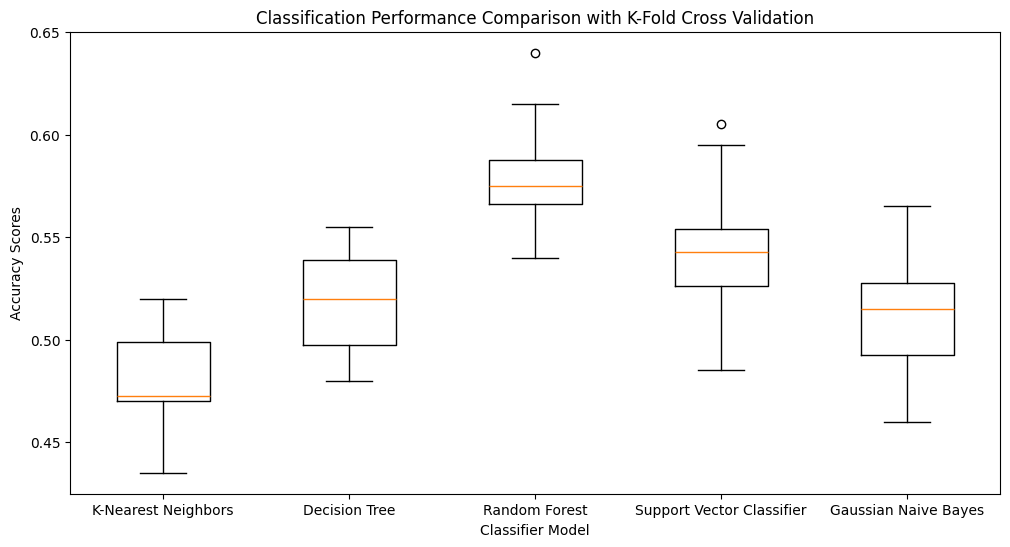

In [ ]:
model_validation(X, y, folds=10)

For the model that performs best, run the model and perform hyper-parameter tuning

In [ ]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.60


## Vectorization using TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
resume_tfidf = tfidf_vectorizer.fit_transform(resume_texts)
jd_tfidf = tfidf_vectorizer.fit_transform(jd_texts)

In [ ]:
X = hstack((resume_tfidf, jd_tfidf)).toarray()
y = resume_match_df['label'].values

100%|██████████| 5/5 [20:20<00:00, 244.00s/it]
<ipython-input-13-0c08bdfe2a30>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))


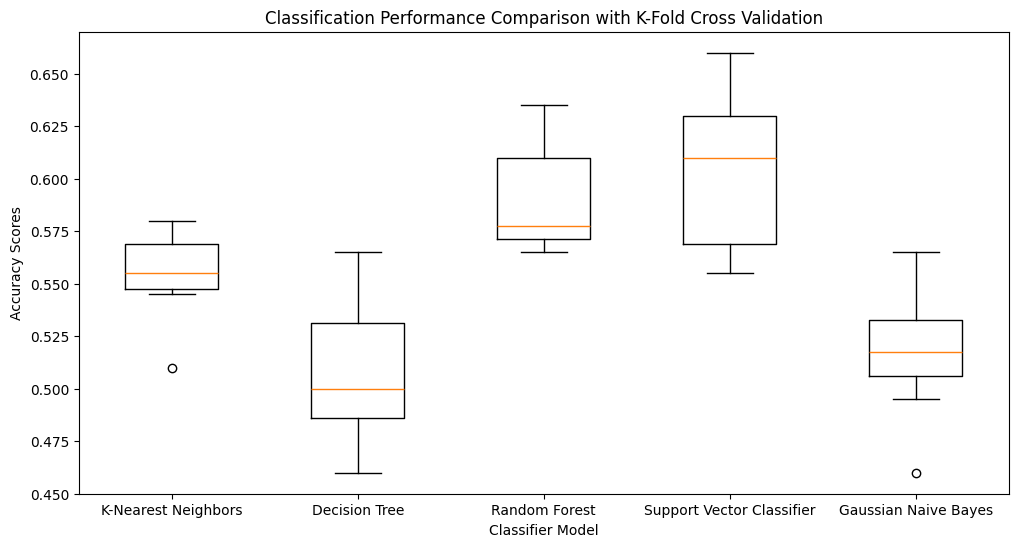

In [ ]:
model_validation(X, y, folds=10)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.64


### TF-IDF Cosine Similarity Evaluation

We combine resume and JD text together because cosine similarity compares vectors of the same dimension

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# split back to resume and jd matrices
cos_sim_resume_tfidf = tfidf_matrix[:len(resume_texts)]
cos_sim_jd_tfidf = tfidf_matrix[len(resume_texts):]

similarity_scores = [cosine_similarity(cos_sim_resume_tfidf[i], cos_sim_jd_tfidf[i])[0][0] for i in range(len(resume_tfidf.toarray()))]

In [ ]:
def classify_similarity_scores(scores):
  similarity_scores = []
  for score in scores:
    if score >= 0.2:
      similarity_scores.append("Good Fit")
    elif score >= 0.1 and score < 0.2:
      similarity_scores.append("Potential Fit")
    elif score < 0.1:
      similarity_scores.append("No Fit")

  predictions = pd.DataFrame(similarity_scores)

  return predictions

cos_sim_pred = classify_similarity_scores(similarity_scores)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y, cos_sim_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.49


In [ ]:
y_df = pd.DataFrame(y)
no_fit_actual = y_df.loc[y_df[0] == "No Fit"].count()[0]
pot_fit_actual = y_df.loc[y_df[0] == "Potential Fit"].count()[0]
good_fit_actual = y_df.loc[y_df[0] == "Good Fit"].count()[0]
no_fit_pred = cos_sim_pred.loc[cos_sim_pred[0] == "No Fit"].count()[0]
pot_fit_pred = cos_sim_pred.loc[cos_sim_pred[0] == "Potential Fit"].count()[0]
good_fit_pred = cos_sim_pred.loc[cos_sim_pred[0] == "Good Fit"].count()[0]
print(f"Good Fit Predictions Count:{good_fit_pred}...Good Fit Actual Count:{good_fit_actual}")
print(f"Potential Fit Predictions Count:{pot_fit_pred}...Potential Fit Actual Count:{pot_fit_actual}")
print(f"Not Fit Predictions Count:{no_fit_pred}...Not Fit Actual Count:{no_fit_actual}")

Good Fit Predictions Count:104...Good Fit Actual Count:486
Potential Fit Predictions Count:458...Potential Fit Actual Count:512
Not Fit Predictions Count:1438...Not Fit Actual Count:1002


## Vectorization using word embeddings (Word2Vec)

In [ ]:
# Combine preprocessed resume and JD tokens for training Word2Vec
all_tokens = preprocessed_resume_text + preprocessed_jd_text

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average Word2Vec vector for a document
def get_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else model.vector_size

# Convert resumes & JDs into numerical vectors
resume_vectors = np.array([get_vector(tokens, word2vec_model) for tokens in preprocessed_resume_text])
jd_vectors = np.array([get_vector(tokens, word2vec_model) for tokens in preprocessed_jd_text])

X = np.hstack((resume_vectors, jd_vectors))
y = resume_match_df['label'].values

100%|██████████| 5/5 [00:28<00:00,  5.77s/it]
<ipython-input-13-0c08bdfe2a30>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))


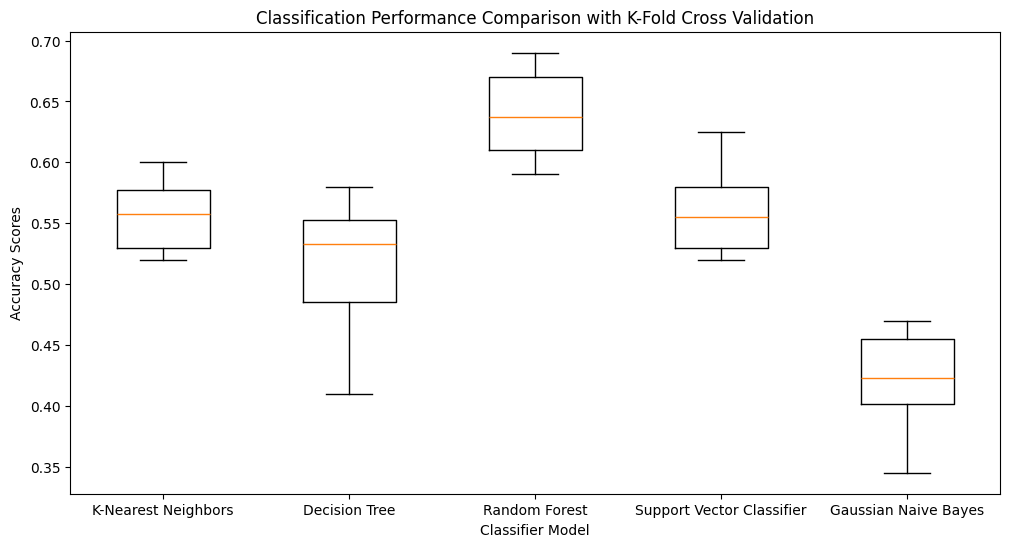

In [ ]:
model_validation(X, y, folds=10)

### Classification using the best performing classifier

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.67


#### Word2Vec Cosine Similarity Evaluation

In [ ]:
similarity_scores_w2v = [cosine_similarity([cos_sim_resume_w2v], [cos_sim_jd_w2v])[0][0] for cos_sim_resume_w2v, cos_sim_jd_w2v in zip(resume_vectors, jd_vectors)]

In [ ]:
cos_sim_pred_w2v = classify_similarity_scores(similarity_scores_w2v)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y, cos_sim_pred_w2v)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.24


### Using Neural Network with word embeddings (Word2Vec & PyTorch)

In [ ]:
# Combine resume and JD vectors into single vectors
X = np.concatenate([resume_vectors, jd_vectors], axis=1)

# Encode labels and convert the features and labels to tensors
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [ ]:
input_dimension = X.shape[1]
hidden_layers = 128
output_dimension = len(np.unique(y_encoded))

# Hyperparameter initialization
learning_rate = 0.01
epochs = 20
batch_size = 32

In [ ]:
# Randomly initialize weights and biases
W1 = torch.randn(input_dimension, hidden_layers, requires_grad=True)
W1.data *= 0.01

b1 = torch.zeros(hidden_layers, requires_grad=True)

W2 = torch.randn(hidden_layers, output_dimension, requires_grad=True)
W2.data *= 0.01

b2 = torch.zeros(output_dimension, requires_grad=True)

optimizer = torch.optim.Adam([W1, b1, W2, b2], lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))  # shuffle

    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        # Forward pass
        z1 = batch_x @ W1 + b1  # Linear
        a1 = F.relu(z1)         # Activation
        z2 = a1 @ W2 + b2       # Output layer
        loss = criterion(z2, batch_y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/60 - Loss: 52.7623
Epoch 2/60 - Loss: 50.3624
Epoch 3/60 - Loss: 48.6046
Epoch 4/60 - Loss: 46.9989
Epoch 5/60 - Loss: 44.8690
Epoch 6/60 - Loss: 43.0920
Epoch 7/60 - Loss: 42.6401
Epoch 8/60 - Loss: 41.3129
Epoch 9/60 - Loss: 41.3397
Epoch 10/60 - Loss: 39.1878
Epoch 11/60 - Loss: 38.2705
Epoch 12/60 - Loss: 37.3073
Epoch 13/60 - Loss: 37.7459
Epoch 14/60 - Loss: 36.1283
Epoch 15/60 - Loss: 35.6265
Epoch 16/60 - Loss: 36.0411
Epoch 17/60 - Loss: 35.0386
Epoch 18/60 - Loss: 33.3978
Epoch 19/60 - Loss: 33.6024
Epoch 20/60 - Loss: 32.6024
Epoch 21/60 - Loss: 32.5360
Epoch 22/60 - Loss: 30.2754
Epoch 23/60 - Loss: 30.7425
Epoch 24/60 - Loss: 30.0807
Epoch 25/60 - Loss: 30.7486
Epoch 26/60 - Loss: 30.6070
Epoch 27/60 - Loss: 29.1071
Epoch 28/60 - Loss: 29.1197
Epoch 29/60 - Loss: 28.3839
Epoch 30/60 - Loss: 28.2061
Epoch 31/60 - Loss: 30.3614
Epoch 32/60 - Loss: 28.2078
Epoch 33/60 - Loss: 26.9141
Epoch 34/60 - Loss: 26.8020
Epoch 35/60 - Loss: 26.1286
Epoch 36/60 - Loss: 26.5330
E

In [ ]:
with torch.no_grad():
    z1 = X_test @ W1 + b1
    a1 = F.relu(z1)
    z2 = a1 @ W2 + b2
    predictions = torch.argmax(z2, dim=1)

    accuracy = (predictions == y_test).float().mean()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.6075


### Using DISTILBERT Pretrained model

In [ ]:
!pip install numpy==1.24.4 --force-reinstall

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

In [ ]:
# Convert label to numeric
resume_match_df['label'] = resume_match_df['label'].map({'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2})

# Convert into list of sentence pairs
texts = list(zip(resume_match_df['resume_text'], resume_match_df['job_description_text']))
labels = resume_match_df['label'].tolist()

In [ ]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=3)

In [ ]:
def tokenize(texts, labels):
    encodings = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(input_ids, attention_mask, labels_tensor)

NameError: name 'Callback' is not defined

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = tokenize(X_train, y_train)
test_dataset = tokenize(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=8)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
def train_model():
    model.train()
    for epoch in range(15):
        print(f"\nEpoch {epoch + 1}")
        loop = tqdm(train_loader)
        for batch in loop:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

train_model()

In [ ]:
def evaluate_model():
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    target_names = ['No Fit', 'Potential Fit', 'Good Fit']
    print(classification_report(all_labels, all_preds, target_names=target_names))

evaluate_model()
